# Истинная орбита МКС - фильтр Калмана

Задача состоит в определении положения и скорости международной космической станции на орбите с наибольшей возможной точностью путём построения алгоритма фильтра Калмана. Движение станции использует ограниченную модель 2 тел и описывается классическими ньютоновскими уравнениями с добавкой второго порядка, вызванной несферичностью Земли. На вход поступают измеренные в текущий момент векторы координат и скорости станции. Измерения производятся с погрешностью. Требуется, используя модель и получаемые измерения определять положение и движение МКС в любой момент времени. Для тестовой задачи дан промежуток времени длиной примерно 1 час 40 минут. 
Параметры для задачи:
$$ \mu = 3.986004418^{14} {{м^3} \over {с^2}} - гравитационный \ \ параметр $$

$$ R = 6371.137 \ км - радиус \ \ Земли $$

$$ J_2 = 0.0010827 \ - второй \ момент $$

$$ \sigma^2_x = 100 \ м^2  - дисперсия \ координаты $$

$$ \sigma^2_v = 10^{-4} \ {{м} \over {с}} - дисперсия \ скорости $$

В задаче вводится вектор состояния, состоящий из фазовых переменных МКС:
$$ \vec{x} =  \left[
  \begin{array}{ccc}
     \vec r \\
     \vec v \\
  \end{array}
\right] = \left[
  \begin{array}{ccc}
     x \\
     y \\
     z \\
     v_x \\
     v_y \\
     v_z \\
  \end{array}
\right] $$

Производные вектора состояния задаются уравнениями:
$$ \dot{\vec{x}} = \left[
  \begin{array}{ccc}
     v_x \\
     v_y \\
     v_z \\
     - {{{\mu x} \over {r^3}} + {{\mu J_2 R^2} \over {2}} ({15 {xz^2} \over {r^7}} - {3 x \over {r^5}})} \\
     - {{{\mu y} \over {r^3}} + {{\mu J_2 R^2} \over {2}} ({15 {yz^2} \over {r^7}} - {3 y \over {r^5}})} \\
     - {{{\mu z} \over {r^3}} + {{\mu J_2 R^2} \over {2}} ({15 {z^3} \over {r^7}} - {9 z \over {r^5}})} \\
  \end{array}
\right] $$

## Алгоритм решения

Общая модель системы (нелинейного процесса):
$$ \dot{x} = f(x, u, t) + w(t) $$
$$ \dot{z} = h(x) + v(t) \ , $$
где f(x, u, t) - функция модели состояния системы, h(x) - функция модели измерений,
а w(t) и v(t), соответственно, ошибки модели состояния и модели наблюдения.

В данной задаче отсутствует управление, а также уравнения движения небесного тела зависят только от фазовых координат,
поэтому f(x, u, t) = f(x), а величина ошибок постоянна во времени, поэтому v(t) = v, w(t) = w.
Таким образом, модель системы упрощается до вида:
$$ \dot{x} = f(x) + w $$
$$ z = h(x) + v $$

Задача от дискретных переменных выглядит следующим образом:
$$ x_k = x_{k-1} + f(x_{k-1}) + w_k $$
$$ z_k = h(x_k) + v_k $$

Будем обозначать:
$$ x_k, P_k - истинное \ состояние \ системы \ и \ матрица \ ковариаций \ ошибок $$
$$ \hat{x_k}, \hat{P_k} - оценка \ состояния \ системы \ и \ матрицы \ ковариаций \ ошибок $$
$$ \overline{x_k}, \overline{P_k} - оценка \ вектора \ состояния \ и \ матрицы \ ковариаций \ ошибок \ по \ модели $$

##### Задача решается в 2 этапа: предиктор и корректор

### Предиктор:
Первым этапом делается прогноз состояния системы по используемым уравнениям модели.
Прогноз (экстраполяция) вектора состояния и матрицы ковариаций ошибок с помощью модели процесса:
$$ \overline{x_k} = f(\hat{x_{k-1}}) $$
$$ \overline{P_k} = \Phi \cdot \hat{P_k} \cdot \Phi^T + Q \ , $$
где
$$ \Phi = E + F \cdot (t_k - t_{k-1} $$
$$ F = \frac{\partial f}{\partial x} \bigg|_{x = \tilde{x_{k-1}}} - якобиан \ функции \ состояния \ модели $$
$$ Q = E [w_k \cdot w_k^T] - матрица \ ковариации \ шумов \ модели \ системы $$

### Корректор:
Вторым этапом полученные значения корректируются с помощью измеренных данных о состоянии модели
Вычисление коэффициента усиления Калмана:
$$ K = \overline{P}_k \cdot H^T \cdot \left(H\cdot \overline{P}_k\cdot H^T + R\right)^{-1} $$
Оценка вектора состояния и матрицы ковариации ошибок:
$$\hat{x}_k = \overline{x}_k + K \cdot\left(z_k - H\cdot\overline{x}_k\right)$$
$$\hat{P}_k = \left(I - K\cdot H\right)\cdot \overline{P}_k \ ,$$
где
$$ H = \frac{\partial f}{\partial x} \bigg|_{x = \tilde{x_{k}}} - якобиан \ функции \ измерения \ модели $$
$$ R = E [v_k \cdot v_k^T] - матрица \ ковариации \ шумов \ модели \ наблюдения $$

## Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

## Функции

In [2]:
def FuncOrbite(t, x): # Функция f(x, t)
    r = np.copy(x[:3])
    r_abs = np.linalg.norm(r)
    v = np.copy(x[3:])
    second_order = (np.array([r[0]*r[2]**2, r[1]*r[2]**2, r[2]**3]) * 15 / r_abs**7 -
                    np.array([3*r[0], 3*r[1], 9*r[2]]) / r_abs**5) * mu * J2 * R**2 / 2 
    return np.concatenate((v, -mu * r / r_abs**3 + second_order), axis=0)

def FuncMeasure(x): # Функция h(x)
    return x

def ModelError(t): # Функция шума модели состояния. Функция может быть любой, но ограниченной
    rng = np.random.default_rng()
    return np.append(Ampl_w_r * rng.random(3), Ampl_w_v * rng.random(3))

def MeasureError(t): # Функция шума модели наблюдения. Функция может быть любой, но ограниченной
    rng = np.random.default_rng()
    return np.append(Ampl_v_r * rng.random(3), Ampl_v_v * rng.random(3))

def JacobianF(x):
    r = np.copy(x[:3])
    r_abs = np.linalg.norm(r)
    Phi = np.zeros((6,6))
    Phi[0:3, 3:6] = np.eye(3)
    a = mu * J2 * R**2 / 2 * (15 * r[2]**2 / r_abs**7 - 3 / r_abs**5)
    b = 15 * mu * J2 * R**2 / r_abs**7 * r[2]
    Phi[3, 0] = -mu / r_abs**3 + a
    Phi[4, 1] = -mu / r_abs**3 + a
    Phi[5, 2] = -mu / r_abs**3 + 3*a
    Phi[3, 2] = b * r[0]
    Phi[4, 2] = b * r[1]
    return Phi

def JacobianH(x):
    return np.eye(6)

def time(str_t):
    A = str_t.split(':')
    for i in range(len(A)):
        if A[i][0:2] == '00':
            if len(A[i]) <= 2:
                A[i] = '0'
            else:
                A[i] = '0' + A[i][2:]
    return int(A[0]) * 3600 + int(A[1]) * 60 + float(A[2])

## Расширенный фильтр Калмана

### Предиктор

In [3]:
def predictorStatus(xk_1, tk_1, tk):
    dt = tk - tk_1
    xk_estimated = xk_1 + FuncOrbite(tk, xk_1) * dt
    return xk_estimated

def predictorCovar(Pk_1, xk_1, tk_1, tk):
    dt = tk - tk_1
    Phi = np.eye(6) + JacobianF(xk_1) * dt
    wk = ModelError(tk_1)
    Q = np.diag(wk**2) # Матрица ковариаций шумов модели
    Pk_estimated = Phi @ Pk_1 @ Phi.T + Q
    return Pk_estimated

### Корректор

In [4]:
def MatrixK(Pk_estimated, xk_estimated, tk):
    vk = MeasureError(tk)
    R = np.diag(vk**2) # Матрица ковариаций шумов модели
    H = JacobianH(xk_estimated)
    
    if np.linalg.det(H @ Pk_estimated @ H.T + R) != 0:
        K = Pk_estimated @ H.T @ np.linalg.inv(H @ Pk_estimated @ H.T + R)
    else:
        K = np.eye(6)
    return K

def correctorStatus(xk_estimated, zk, K):
    xk = xk_estimated + K @ (zk - FuncMeasure(xk_estimated))
    return xk

def correctorCovar(Pk_estimated, xk, K):
    Pk = (np.eye(6) - K @ JacobianH(xk)) @ Pk_estimated
    return Pk

## Параметры

In [5]:
mu = 3.986004418e5
J2 = 0.0010827
R = 6378.137

# Параметры для w(t) - погрешности модели:
Ampl_w_r = 1e-2
Ampl_w_v = 1e-5

# Параметры для v(t) - погрешности измерения:
Ampl_v_r = 1e-2
Ampl_v_v = 1e-5

## Рабочая область

In [13]:
data = pd.read_csv("iss_test.txt", delim_whitespace=True)
N = len(data.iloc[:,0])
x = np.array(data.iloc[0, 1:])
P = np.diag([Ampl_w_r, Ampl_w_r, Ampl_w_r, Ampl_w_v, Ampl_w_v, Ampl_w_v])
status = data.copy(deep=True)
estimation = data.copy(deep=True)
for i in range(1, data.shape[0]):
    t_curr = time(data.iloc[i, 0])
    t_prev = time(data.iloc[i-1, 0])
    x_est = predictorStatus(x, t_prev, t_curr)
    P_est = predictorCovar(P, x, t_prev, t_curr)
    K = MatrixK(P_est, x_est, t_curr)
    z = np.array(data.iloc[i, 1:]) + MeasureError(t_curr)
    x = correctorStatus(x_est, z, K)
    P = correctorCovar(P_est, x, K)
    status.iloc[i, 1:] = x
    estimation.iloc[i, 1:] = x_est

# Поиск максимальной ошибки
max_norm = [0, 0, 0, 0] # Первый и второй элементы - норма между состоянием и предсказанием координат и скоростей
                        # Второй - норма между состоянием и измерением координат и скоростей
for i in range(N):
    if norm(status.iloc[i, 1:4] - estimation.iloc[i, 1:4]) > max_norm[0]:
        max_norm[0] = norm(status.iloc[i, 1:4] - estimation.iloc[i, 1:4])
    if norm(status.iloc[i, 1:4] - data.iloc[i, 1:4]) > max_norm[1]:
        max_norm[1] = norm(status.iloc[i, 1:4] - data.iloc[i, 1:4])
    if norm(status.iloc[i, 4:] - estimation.iloc[i, 4:]) > max_norm[2]:
        max_norm[2] = norm(status.iloc[i, 4:] - estimation.iloc[i, 4:])
    if norm(status.iloc[i, 4:] - data.iloc[i, 4:]) > max_norm[3]:
        max_norm[3] = norm(status.iloc[i, 4:] - data.iloc[i, 4:])

## Отображение результатов:

Y-coordinate from time:
1  Jan  2000       0.000000
        2000       4.713716
        2000       9.428910
        2000      14.144730
        2000      18.861746
                   ...     
        2000    1902.122588
        2000    1906.317895
        2000    1910.514946
        2000    1914.707733
        2000    1918.898433
Name: DefaultSC.EarthMJ2000Eq.Y, Length: 6001, dtype: float64


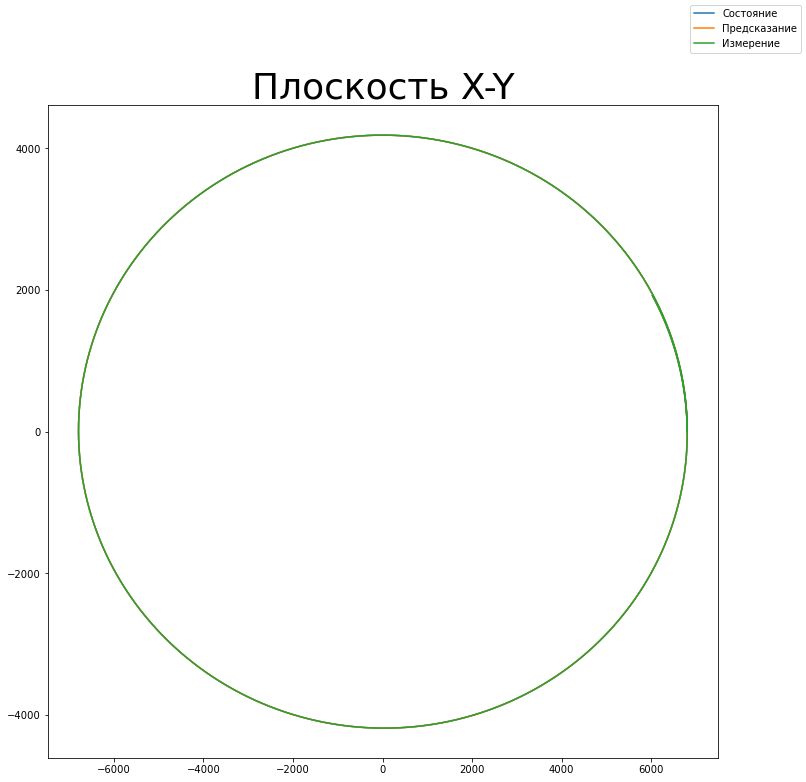

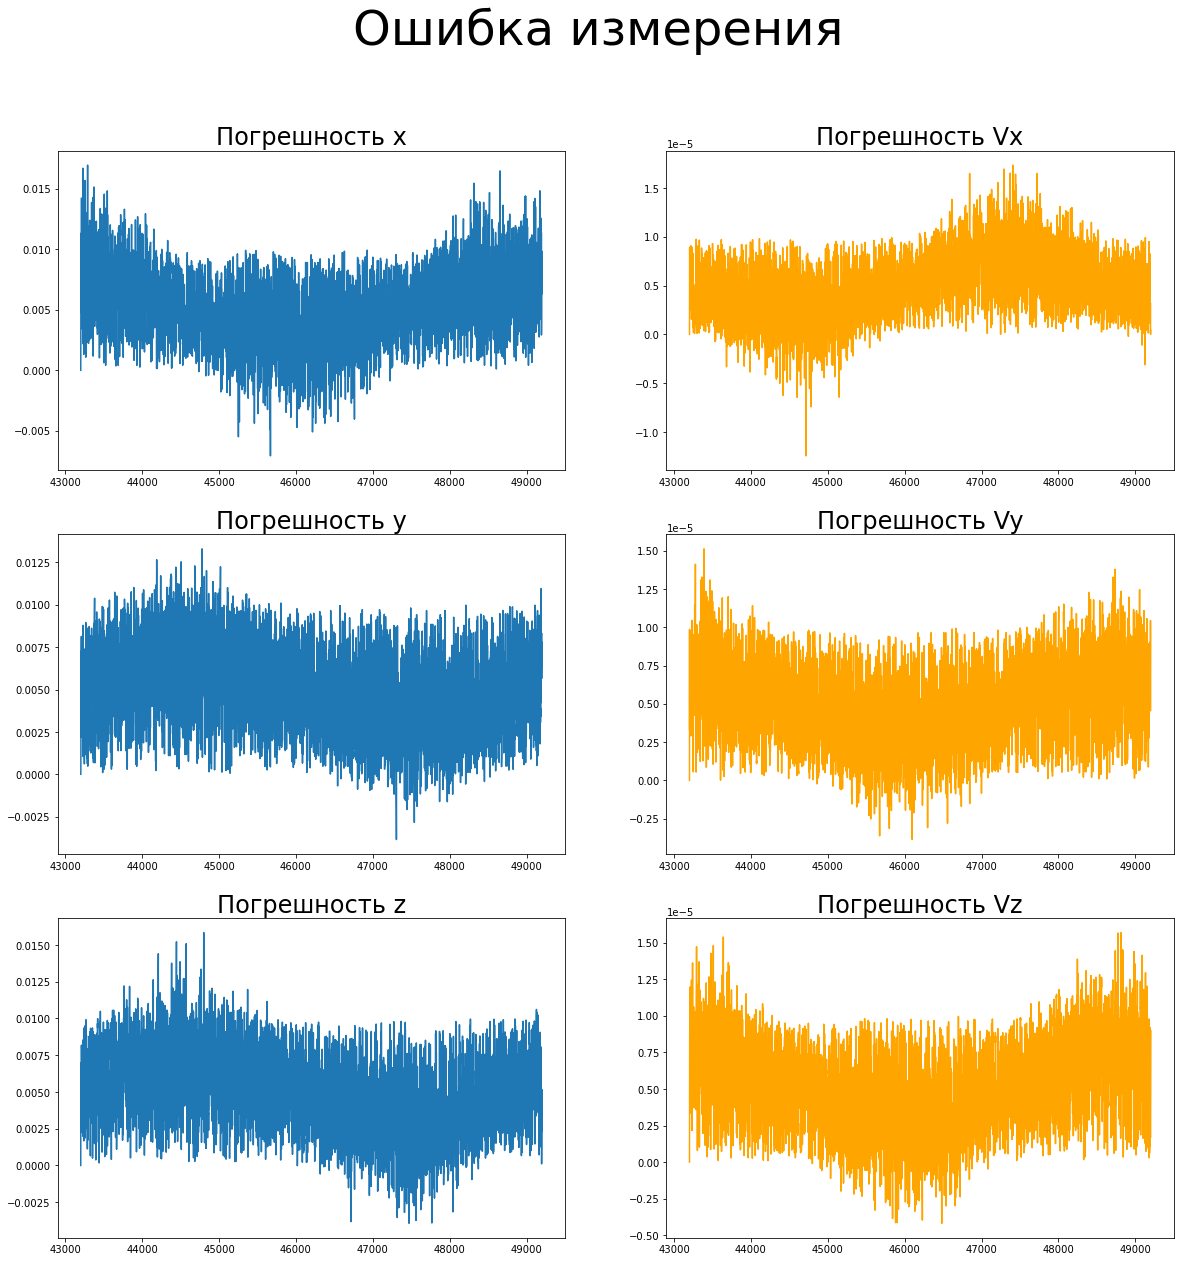

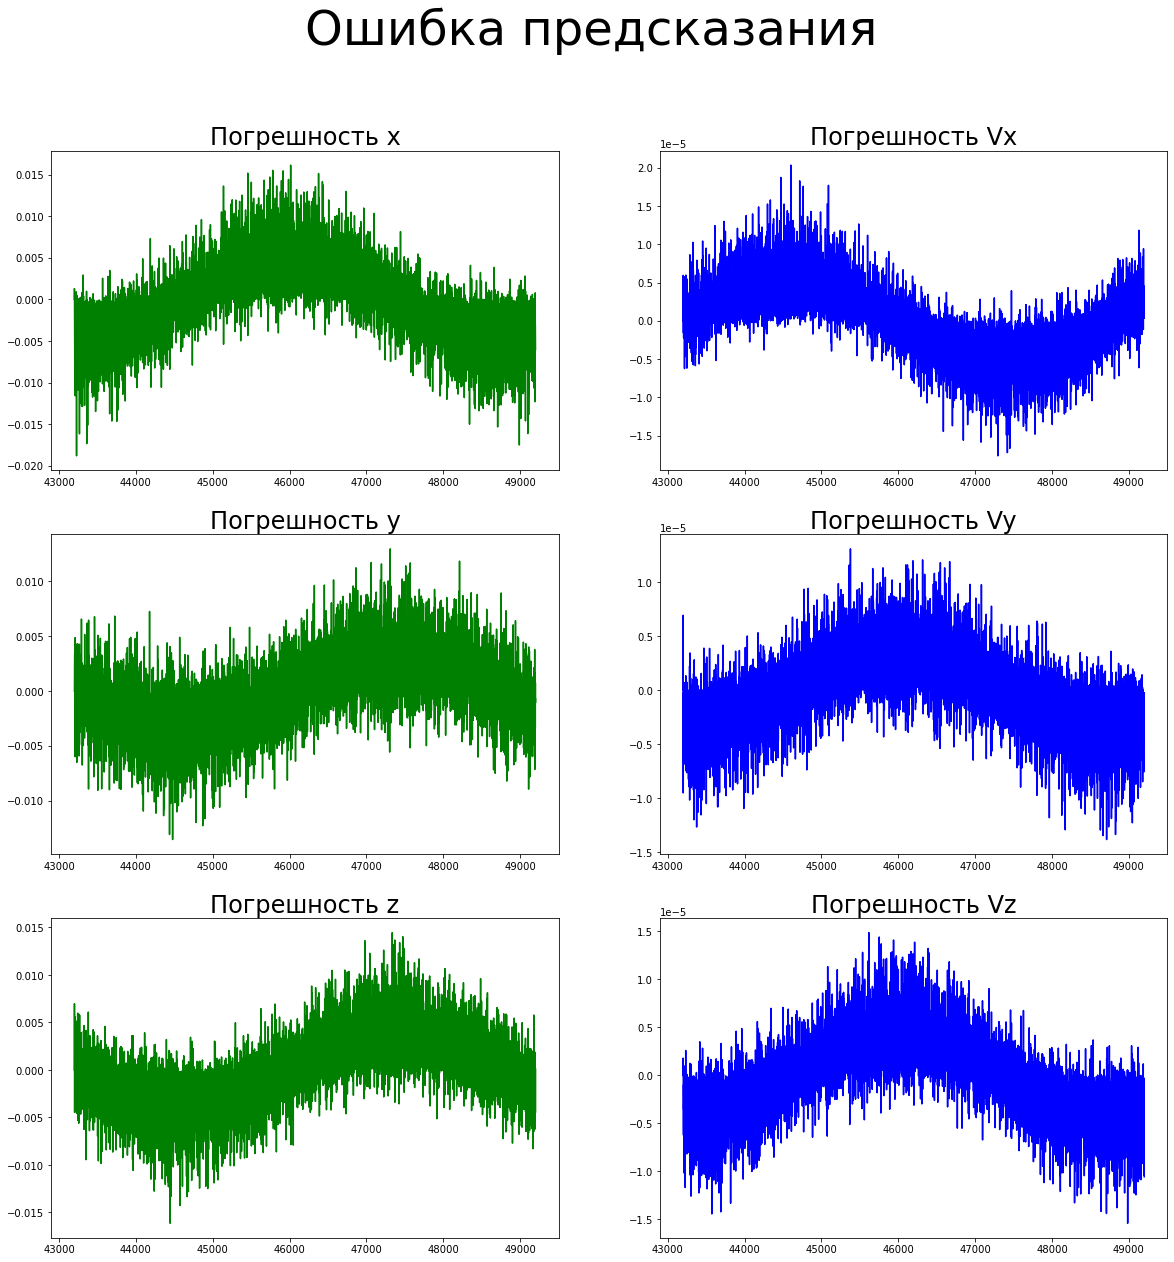

Максимальная ошибка по координате в предсказании:  0.019822347135161313
Максимальная ошибка по скорости в предсказании:  2.0401777201819886e-05
Максимальная ошибка по координате в измерении:  0.019267954782040797
Максимальная ошибка по скорости в измерении:  2.1098471760066566e-05


In [14]:
print("Y-coordinate from time:")
print(status.iloc[:, 2])

fig_XY, ax_XY = plt.subplots(figsize=(12, 12))
ax_XY.plot(status.iloc[:, 1], status.iloc[:, 2], label="Состояние")
ax_XY.plot(estimation.iloc[:, 1], estimation.iloc[:, 2], label="Предсказание")
ax_XY.plot(data.iloc[:, 1], data.iloc[:, 2], label="Измерение")
ax_XY.set_title("Плоскость X-Y", size=36)
fig_XY.legend()

Timeline = list(map(time, data.iloc[:, 0]))
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
fig.suptitle("Ошибка измерения", size=48)
ax[0][0].plot(Timeline, status.iloc[:, 1]-data.iloc[:, 1])
ax[1][0].plot(Timeline, status.iloc[:, 2]-data.iloc[:, 2])
ax[2][0].plot(Timeline, status.iloc[:, 3]-data.iloc[:, 3])
ax[0][1].plot(Timeline, status.iloc[:, 4]-data.iloc[:, 4], "orange")
ax[1][1].plot(Timeline, status.iloc[:, 5]-data.iloc[:, 5], "orange")
ax[2][1].plot(Timeline, status.iloc[:, 6]-data.iloc[:, 6], "orange")
ax[0][0].set_title("Погрешность x", size=24)
ax[1][0].set_title("Погрешность y", size=24)
ax[2][0].set_title("Погрешность z", size=24)
ax[0][1].set_title("Погрешность Vx", size=24)
ax[1][1].set_title("Погрешность Vy", size=24)
ax[2][1].set_title("Погрешность Vz", size=24)

fig2, ax2 = plt.subplots(3, 2, figsize=(20, 20))
fig2.suptitle("Ошибка предсказания", size=48)
ax2[0][0].plot(Timeline, status.iloc[:, 1]-estimation.iloc[:, 1], "green")
ax2[1][0].plot(Timeline, status.iloc[:, 2]-estimation.iloc[:, 2], "green")
ax2[2][0].plot(Timeline, status.iloc[:, 3]-estimation.iloc[:, 3], "green")
ax2[0][1].plot(Timeline, status.iloc[:, 4]-estimation.iloc[:, 4], "blue")
ax2[1][1].plot(Timeline, status.iloc[:, 5]-estimation.iloc[:, 5], "blue")
ax2[2][1].plot(Timeline, status.iloc[:, 6]-estimation.iloc[:, 6], "blue")
ax2[0][0].set_title("Погрешность x", size=24)
ax2[1][0].set_title("Погрешность y", size=24)
ax2[2][0].set_title("Погрешность z", size=24)
ax2[0][1].set_title("Погрешность Vx", size=24)
ax2[1][1].set_title("Погрешность Vy", size=24)
ax2[2][1].set_title("Погрешность Vz", size=24)

plt.show()

print("Максимальная ошибка по координате в предсказании: ", max_norm[0])
print("Максимальная ошибка по скорости в предсказании: ", max_norm[2])
print("Максимальная ошибка по координате в измерении: ", max_norm[1])
print("Максимальная ошибка по скорости в измерении: ", max_norm[3])